In [1]:
import math
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
n = 256
R = 25.5/2
u = np.linspace(-1,1,256)*R
x,y = np.meshgrid(u,u)
xy = np.array( [ x.flatten(), y.flatten()] )

In [19]:
def ROT(o):
    return np.array([ [ math.cos(o), math.sin(o)], [-math.sin(o),math.cos(o)] ])
rc = 4.387
xy_rc = np.array([[0],[rc]])
print xy_rc
rp = 7.543
xy_rp = np.array([[rp],[0]])
print xy_rp
W = 1.5
L = 1.5

[[ 0.   ]
 [ 4.387]]
[[ 7.543]
 [ 0.   ]]


In [20]:
M = False
for k in range(6):
    theta = k*math.pi/3
    #print ROT(theta)
    xyp = np.dot(ROT(theta),xy) + xy_rc
    M = np.logical_or( M , np.logical_and( np.abs(xyp[0,:])<L/2,  np.abs(xyp[1,:])<W/2 ) )
for k in range(6):
    theta = k*math.pi/3
    #print ROT(theta)
    xyp = np.dot(ROT(theta),xy) - xy_rp
    M = np.logical_or( M , np.logical_and( np.abs(xyp[0,:])<L/2,  np.abs(xyp[1,:])<W/2 ) )

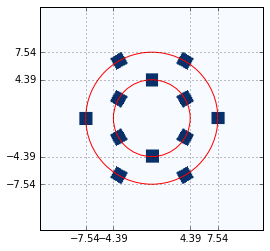

In [21]:
fig,ax =subplots()
ax.imshow(M.reshape((n,n)),extent=[-R,R,-R,R],cmap='Blues')
Circle((0,0),radius=rp)
grid()
xticks([-rp,-rc,rc,rp])
yticks([-rp,-rc,rc,rp])
c1 = Circle((0,0),radius=rc, color='r', fill=False)
ax.add_patch(c1)
c2 = Circle((0,0),radius=rp, color='r', fill=False)
ax.add_patch(c2)